In [32]:
import torch
import matplotlib.pyplot as plt
import non_local_boxes
import numpy as np
from IPython.display import clear_output   # in order to clear the print output

# Sugar coating for reloading
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
W = [0.,0.,1.,1.,1.,1.,0.,0.,0.,1.,1.,0.,1.,0.,0.,0.,0.,1.,1.,0.,1.,0.,0.,1.,0.,1.,1.,0.,0.,1.,1.,0.]
non_local_boxes.utils.wiring_to_functions(W)

f_1(x,a2) = x
g_1(y,b2) = y ⊕ 1.0 
f_2(x,a1) = x ⊕ a1
g_2(y,b1) = y ⊕ b1 ⊕ y·b1 ⊕ 1.0 
f_3(x,a1,a2) = x ⊕ a1 ⊕ a2
g_3(y,b1,b2) = b1 ⊕ b2


In [34]:
W = [0.,0.,1.,1.,0.,0.,1.,1.,0.,0.,0.,1.,0.,0.,0.,1.,1.,0.,0.,1.,1.,0.,0.,1.,0.,1.,1.,0.,1.,0.,0.,1.]
non_local_boxes.utils.wiring_to_functions(W)

f_1(x,a2) = x
g_1(y,b2) = y
f_2(x,a1) = x·a1
g_2(y,b1) = y·b1
f_3(x,a1,a2) = a1 ⊕ a2 ⊕ 1.0 
g_3(y,b1,b2) = y ⊕ b1 ⊕ b2


# Definitions

## Gradient Descent

In [35]:
M1 = torch.zeros(32, 32)
for i in range(32):
    M1[i,i]=1
M1[0,0]=0.5
M1[0,1]=0.5
M1[1,0]=0.5
M1[1,1]=0.5

M2 = torch.zeros(32, 32)
for i in range(32):
    M2[i,i]=1
M2[8,8]=0.5
M2[8,9]=0.5
M2[9,8]=0.5
M2[9,9]=0.5

M3 = torch.zeros(32, 32)
for i in range(32):
    M3[i,i]=1
M3[2,2]=0.5
M3[2,3]=0.5
M3[3,2]=0.5
M3[3,3]=0.5

M4 = torch.zeros(32, 32)
for i in range(32):
    M4[i,i]=1
M4[10,10]=0.5
M4[10,11]=0.5
M4[11,10]=0.5
M4[11,11]=0.5

M5 = torch.zeros(32, 32)
for i in range(32):
    M5[i,i]=1
M5[4,4]=0.5
M5[4,5]=0.5
M5[5,4]=0.5
M5[5,5]=0.5

M6 = torch.zeros(32, 32)
for i in range(32):
    M6[i,i]=1
M6[12,12]=0.5
M6[12,13]=0.5
M6[13,12]=0.5
M6[13,13]=0.5

M7 = torch.zeros(32, 32)
for i in range(32):
    M7[i,i]=1
M7[6,6]=0.5
M7[6,7]=0.5
M7[7,6]=0.5
M7[7,7]=0.5

M8 = torch.zeros(32, 32)
for i in range(32):
    M8[i,i]=1
M8[14,14]=0.5
M8[14,15]=0.5
M8[15,14]=0.5
M8[15,15]=0.5

In [36]:
def projected_wiring(W):  # W is a 32xn tensor
    W = torch.maximum(W, torch.zeros_like(W))  # it outputs the element-wise maximum
    W = torch.minimum(W, torch.ones_like(W))   # similarly for minimum

    T1 = (torch.abs(W[0,:]-W[1,:]) <= torch.abs(W[8, :] - W[9, :]))
    W = T1*torch.tensordot(M1, W, dims=1) + torch.logical_not(T1)*torch.tensordot(M2, W, dims=1)
    
    T2 = (torch.abs(W[2,:]-W[3,:]) <= torch.abs(W[10, :] - W[11, :]))
    W = T2*torch.tensordot(M3, W, dims=1) + torch.logical_not(T2)*torch.tensordot(M4, W, dims=1)

    T3 = (torch.abs(W[4,:]-W[5,:]) <= torch.abs(W[12, :] - W[13, :]))
    W = T3*torch.tensordot(M5, W, dims=1) + torch.logical_not(T3)*torch.tensordot(M6, W, dims=1)

    T4 = (torch.abs(W[6,:]-W[7,:]) <= torch.abs(W[14, :] - W[15, :]))
    W = T4*torch.tensordot(M7, W, dims=1) + torch.logical_not(T4)*torch.tensordot(M8, W, dims=1)

    return W

In [37]:
def gradient_descent(starting_W, P, Q, learning_rate = 2, nb_iterations = 20):
    external_grad = torch.ones(non_local_boxes.evaluate.nb_columns)
    W = starting_W
    for i in range(nb_iterations):
        non_local_boxes.evaluate.phi_flat(W, P, Q).backward(gradient=external_grad)
        W = projected_wiring(W + learning_rate*W.grad).detach()  # create a brand new tensor, forgeting the previous gradient
        W.requires_grad=True
    return W

## Test in some triangle

In [38]:
def new_color(value, threshold, k, max_box_power_GD):
    if value > threshold:
        return (0, 0.1*(1-k/max_box_power_GD)+1*(k/max_box_power_GD), 0.1*(1-k/max_box_power_GD)+1*(k/max_box_power_GD))
    return "orangered"

In [39]:
def next_Q(Q, P, W0, color_point, k, max_box_power_GD, learning_rate, nb_iterations, threshold): # Q is a 2x2x2x2 tensor
    if color_point == "orangered":
        W = gradient_descent(W0, non_local_boxes.utils.tensor_to_matrix(Q), P, learning_rate, nb_iterations)
        list = non_local_boxes.evaluate.phi_flat(W, non_local_boxes.utils.tensor_to_matrix(Q), P).detach().numpy()
        index, value = max(enumerate(list), key=lambda x: x[1])  # find the best value in list
        best_wiring = W[:,index].detach()
        best_wiring = torch.t(best_wiring.repeat(non_local_boxes.evaluate.nb_columns, 1))
        new_Q = non_local_boxes.evaluate.R(best_wiring, non_local_boxes.utils.tensor_to_matrix(Q), P)[:,:,:,:,0]
        color_point = new_color(value, threshold, k, max_box_power_GD)
        #print(value)
        best_wiring.requires_grad = True
    else:
        new_Q = Q
        best_wiring = W0
    return new_Q, best_wiring, color_point

In [40]:
def test_box_power(Q, P, W0, n, color_point, k, max_box_power_GD, max_box_power, learning_rate, nb_iterations, threshold): # Q is a 2x2x2x2 tensor
    for l in range(max_box_power):
        if color_point != "orangered":
            break
        Q=non_local_boxes.evaluate.R(W0, non_local_boxes.utils.tensor_to_matrix(Q), P)[:,:,:,:,0]
        value = float(non_local_boxes.evaluate.h_flat(Q))
        color_point = new_color(value, threshold, k, max_box_power_GD)

    return color_point

In [41]:
def draw_triangle(Box1, Box1_name, Box2, Box2_name, Box3, Box3_name, box_grid_size, max_box_power_GD, max_box_power, learning_rate, nb_iterations, threshold): # Box is a 4x4 tensor
    X = torch.tensor([[1,3], [4,1], [4, 5]]).numpy()
    triangle = plt.Polygon(X[:3,:], color="snow")
    plt.gca().add_patch(triangle)

    n = non_local_boxes.evaluate.nb_columns

    for i in range(box_grid_size+1):
        for j in range(box_grid_size-i+1):
            alpha, beta = i/box_grid_size, j/box_grid_size
            P = alpha*Box1 + beta*Box2 + (1-alpha-beta)*Box3   # P is a 4x4 matrix
            color_point = "orangered"

            Q=non_local_boxes.utils.matrix_to_tensor(torch.clone(P))  # Q is a 2x2x2x2 tensor 
            value = float(non_local_boxes.evaluate.h_flat(Q))
            color_point = new_color(value, threshold, 0, max_box_power_GD)
            best_wiring = non_local_boxes.utils.random_wiring(n)

            for k in range(max_box_power_GD-1):
                Q, best_wiring, color_point = next_Q(Q, P, best_wiring, color_point, k+1, max_box_power_GD, learning_rate, nb_iterations, threshold)
                color_point = test_box_power(Q, P, best_wiring, n, color_point, k+1, max_box_power_GD, max_box_power, learning_rate, nb_iterations, threshold)

            plt.plot(X[0,0]*alpha + X[1,0]*beta + X[2,0]*(1-alpha-beta), X[0,1]*alpha + X[1,1]*beta + X[2,1]*(1-alpha-beta), 'o', markersize=3, color=color_point)
                    
    plt.text(X[0,0], X[0,1]+0.1, Box1_name, horizontalalignment='center')
    plt.text(X[1,0]+0.1, X[1,1], Box2_name, verticalalignment='center')
    plt.text(X[2,0]+0.1, X[2,1], Box3_name, verticalalignment='center')
    plt.show()

In [42]:
"""draw_triangle(
    Box1=non_local_boxes.utils.PR,
    Box1_name = "PR",
    Box2=non_local_boxes.utils.P_0,
    Box2_name = "P0",
    Box3 = non_local_boxes.utils.P_1,
    Box3_name = "P1",
    box_grid_size = 40,
    max_box_power_GD = 2,
    max_box_power = 50,
    learning_rate = 2,
    nb_iterations = 40,
    threshold = (3 + float(torch.sqrt(torch.tensor(6))))/6
)"""

'draw_triangle(\n    Box1=non_local_boxes.utils.PR,\n    Box1_name = "PR",\n    Box2=non_local_boxes.utils.P_0,\n    Box2_name = "P0",\n    Box3 = non_local_boxes.utils.P_1,\n    Box3_name = "P1",\n    box_grid_size = 40,\n    max_box_power_GD = 2,\n    max_box_power = 50,\n    learning_rate = 2,\n    nb_iterations = 40,\n    threshold = (3 + float(torch.sqrt(torch.tensor(6))))/6\n)'

## Naive test in some triangle

In [43]:
def draw_triangle_naive(Box1, Box1_name, Box2, Box2_name, Box3, Box3_name, box_grid_size, max_box_power, threshold): # P is a 4x4 tensor
    X = torch.tensor([[1,3], [4,1], [4, 5]]).numpy()
    triangle = plt.Polygon(X[:3,:], color="snow")
    plt.gca().add_patch(triangle)

    n = non_local_boxes.evaluate.nb_columns
    W_random = non_local_boxes.utils.random_wiring(n)

    for i in range(box_grid_size+1):
        for j in range(box_grid_size-i+1):
            alpha, beta = i/box_grid_size, j/box_grid_size
            P = alpha*Box1 + beta*Box2 + (1-alpha-beta)*Box3   # P is a 4x4 matrix
            color_point = "orangered"

            Q=non_local_boxes.utils.matrix_to_tensor(torch.clone(P))  # Q is a 2x2x2x2 tensor 
            value = float(non_local_boxes.evaluate.h_flat(Q))

            if value > threshold:
                color_point = (0, 0.1, 0.1)
                #print(value)
            else:
                # Given a box P, we look for the W maximizing P x_W P
                W = gradient_descent(W_random, P, P, learning_rate=2, nb_iterations=20)
                list = non_local_boxes.evaluate.phi_flat(W, P, P).detach().numpy()
                index, value = max(enumerate(list), key=lambda x: x[1])
                best_wiring = W[:,index].detach()
                best_wiring = torch.t(best_wiring.repeat(non_local_boxes.evaluate.nb_columns, 1))
                #print(value)
                
                for k in range(max_box_power+1):
                    if non_local_boxes.evaluate.h_flat(Q)[0] > threshold:
                        color_point = (0, 0.1*(1-k/max_box_power)+1*(k/max_box_power), 0.1*(1-k/max_box_power)+1*(k/max_box_power))
                        break
                    Q=non_local_boxes.evaluate.R(best_wiring, non_local_boxes.utils.tensor_to_matrix(Q), P)[:,:,:,:,0]

            plt.plot(X[0,0]*alpha + X[1,0]*beta + X[2,0]*(1-alpha-beta), X[0,1]*alpha + X[1,1]*beta + X[2,1]*(1-alpha-beta), 'o', markersize=3, color=color_point)
                    
    plt.text(X[0,0], X[0,1]+0.1, Box1_name, horizontalalignment='center')
    plt.text(X[1,0]+0.1, X[1,1], Box2_name, verticalalignment='center')
    plt.text(X[2,0]+0.1, X[2,1], Box3_name, verticalalignment='center')
    plt.show()

In [44]:
"""draw_triangle_naive(
    Box1=non_local_boxes.utils.PR,
    Box1_name = "PR",
    Box2=non_local_boxes.utils.P_0,
    Box2_name = "P0",
    Box3 = non_local_boxes.utils.P_1,
    Box3_name = "P1",
    box_grid_size = 40,
    max_box_power = 50,
    threshold = (3 + float(torch.sqrt(torch.tensor(6))))/6
)"""

'draw_triangle_naive(\n    Box1=non_local_boxes.utils.PR,\n    Box1_name = "PR",\n    Box2=non_local_boxes.utils.P_0,\n    Box2_name = "P0",\n    Box3 = non_local_boxes.utils.P_1,\n    Box3_name = "P1",\n    box_grid_size = 40,\n    max_box_power = 50,\n    threshold = (3 + float(torch.sqrt(torch.tensor(6))))/6\n)'

## With blue cones: it's dangerous because the triangle is not stable under all wirings

We check if the starting box $P$ is a in the blue cone of another box, but we don't check the powers of $P$ because they could be outside of the triangle.

In [45]:
def is_in_a_blue_cone(xP, yP, blue_points, X): # It tests if Box located at (x, y) is in the cone of a blue box
    # list is a list of coordinates (x0, y0) such that h(P)<0.91 but P is blue
    for point in blue_points:
        x0, y0 = point
        f = lambda x : X[1,1]*(x-x0)/(X[1,0]-x0) + y0*(x-X[1,0])/(x0-X[1,0])  # Lagrange interpolation
        g = lambda x : X[2,1]*(x-x0)/(X[2,0]-x0) + y0*(x-X[2,0])/(x0-X[2,0])  # Lagrange interpolation
        if yP <= f(xP) and yP >= g(xP):
            return True
    return False

In [46]:
def new_color_with_blue_cones(value, threshold, blue_points, X, k, xP, yP, max_box_power_GD):
    if value > threshold:
        blue_points.append((xP,yP))
        return blue_points, (0, 0.1*(1-k/max_box_power_GD)+1*(k/max_box_power_GD), 0.1*(1-k/max_box_power_GD)+1*(k/max_box_power_GD))
    return blue_points, "orangered"

In [47]:
def next_Q_with_blue_cones(Q, P, W0, color_point, k, max_box_power_GD, learning_rate, nb_iterations, threshold, blue_points, X, xP, yP): # Q is a 2x2x2x2 tensor
    if color_point == "orangered":
        W = gradient_descent(W0, non_local_boxes.utils.tensor_to_matrix(Q), P, learning_rate, nb_iterations)
        list = non_local_boxes.evaluate.phi_flat(W, non_local_boxes.utils.tensor_to_matrix(Q), P).detach().numpy()
        index, value = max(enumerate(list), key=lambda x: x[1])  # find the best value in list
        best_wiring = W[:,index].detach()
        best_wiring = torch.t(best_wiring.repeat(non_local_boxes.evaluate.nb_columns, 1))
        new_Q = non_local_boxes.evaluate.R(best_wiring, non_local_boxes.utils.tensor_to_matrix(Q), P)[:,:,:,:,0]
        blue_points, color_point = new_color_with_blue_cones(value, threshold, blue_points, X, k, xP, yP, max_box_power_GD)
        #print(value)
        best_wiring.requires_grad = True
    else:
        new_Q = Q
        best_wiring = W0
    return new_Q, best_wiring, blue_points, color_point

In [48]:
def test_box_power_with_blue_cones(Q, P, W0, n, color_point, k, max_box_power_GD, max_box_power, learning_rate, nb_iterations, threshold, blue_points, X, xP, yP): # Q is a 2x2x2x2 tensor
    Q = torch.clone(Q)
    for l in range(max_box_power):
        if color_point != "orangered":
            break
        Q=non_local_boxes.evaluate.R(W0, non_local_boxes.utils.tensor_to_matrix(Q), P)[:,:,:,:,0]
        value = float(non_local_boxes.evaluate.h_flat(Q))
        blue_points, color_point = new_color_with_blue_cones(value, threshold, blue_points, X, k, xP, yP, max_box_power_GD)

    return blue_points, color_point

In [49]:
def draw_triangle_with_blue_cones(Box1, Box1_name, Box2, Box2_name, Box3, Box3_name, box_grid_size, max_box_power_GD, max_box_power, learning_rate, nb_iterations, threshold): # P is a 4x4 tensor
    X = torch.tensor([[1,3], [4,1], [4, 5]]).numpy()
    triangle = plt.Polygon(X[:3,:], color="snow")
    plt.gca().add_patch(triangle)

    n = non_local_boxes.evaluate.nb_columns
    blue_points = []

    for i in range(box_grid_size+1):
        for j in range(box_grid_size-i+1):
            alpha, beta = i/box_grid_size, j/box_grid_size
            xP, yP = X[0,0]*alpha + X[1,0]*beta + X[2,0]*(1-alpha-beta), X[0,1]*alpha + X[1,1]*beta + X[2,1]*(1-alpha-beta)
            P = alpha*Box1 + beta*Box2 + (1-alpha-beta)*Box3   # P is a 4x4 matrix
            color_point = "orangered"

            if is_in_a_blue_cone(xP, yP, blue_points, X):
                color_point = (0, 0.1, 0.1)
            else:
                Q=non_local_boxes.utils.matrix_to_tensor(torch.clone(P))  # Q is a 2x2x2x2 tensor 
                value = float(non_local_boxes.evaluate.h_flat(Q))
                blue_points, color_point = new_color_with_blue_cones(value, threshold, blue_points, X, 0, xP, yP, max_box_power_GD)
                best_wiring = non_local_boxes.utils.random_wiring(n)

                for k in range(max_box_power_GD-1):
                    Q, best_wiring, blue_points, color_point = next_Q_with_blue_cones(Q, P, best_wiring, color_point, k+1, max_box_power_GD, learning_rate, nb_iterations, threshold, blue_points, X, xP, yP)
                    blue_points, color_point = test_box_power_with_blue_cones(Q, P, best_wiring, n, color_point, k+1, max_box_power_GD, max_box_power, learning_rate, nb_iterations, threshold, blue_points, X, xP, yP)

            plt.plot(xP, yP, 'o', markersize=3, color=color_point)
                    
    plt.text(X[0,0], X[0,1]+0.1, Box1_name, horizontalalignment='center')
    plt.text(X[1,0]+0.1, X[1,1], Box2_name, verticalalignment='center')
    plt.text(X[2,0]+0.1, X[2,1], Box3_name, verticalalignment='center')
    plt.show()

In [50]:
"""draw_triangle_with_blue_cones(
    Box1=non_local_boxes.utils.PR,
    Box1_name = "PR",
    Box2=non_local_boxes.utils.P_0,
    Box2_name = "P0",
    Box3 = non_local_boxes.utils.P_1,
    Box3_name = "P1",
    box_grid_size = 40,
    max_box_power_GD = 3,
    max_box_power = 10,
    learning_rate = 2,
    nb_iterations = 20,
    threshold = (3 + float(torch.sqrt(torch.tensor(6))))/6
)"""

'draw_triangle_with_blue_cones(\n    Box1=non_local_boxes.utils.PR,\n    Box1_name = "PR",\n    Box2=non_local_boxes.utils.P_0,\n    Box2_name = "P0",\n    Box3 = non_local_boxes.utils.P_1,\n    Box3_name = "P1",\n    box_grid_size = 40,\n    max_box_power_GD = 3,\n    max_box_power = 10,\n    learning_rate = 2,\n    nb_iterations = 20,\n    threshold = (3 + float(torch.sqrt(torch.tensor(6))))/6\n)'

## With the rerun option

We run again the gradient descent, but we keep the list `blue_points`.

In [51]:
def draw_triangle_with_rerun(Box1, Box1_name, Box2, Box2_name, Box3, Box3_name, box_grid_size, max_box_power_GD, max_box_power, learning_rate, nb_iterations, threshold, rerun_count): # P is a 4x4 tensor
    X = torch.tensor([[1,3], [4,1], [4, 5]]).numpy()
    triangle = plt.Polygon(X[:3,:], color="snow")
    plt.gca().add_patch(triangle)

    n = non_local_boxes.evaluate.nb_columns
    blue_points = []
    
    for run in range(rerun_count):
        clear_output()
        print(" ----- Run number ", run)
        for i in range(box_grid_size+1):
            for j in range(box_grid_size-i+1):
                alpha, beta = i/box_grid_size, j/box_grid_size
                xP, yP = X[0,0]*alpha + X[1,0]*beta + X[2,0]*(1-alpha-beta), X[0,1]*alpha + X[1,1]*beta + X[2,1]*(1-alpha-beta)
                P = alpha*Box1 + beta*Box2 + (1-alpha-beta)*Box3   # P is a 4x4 matrix
                color_point = "orangered"

                if is_in_a_blue_cone(xP, yP, blue_points, X):
                    color_point = (0, 0.1, 0.1)
                else:
                    Q=non_local_boxes.utils.matrix_to_tensor(torch.clone(P))  # Q is a 2x2x2x2 tensor 
                    value = float(non_local_boxes.evaluate.h_flat(Q))
                    blue_points, color_point = new_color_with_blue_cones(value, threshold, blue_points, X, 0, xP, yP, max_box_power_GD)
                    best_wiring = non_local_boxes.utils.random_wiring(n)

                    for k in range(max_box_power_GD-1):
                        Q, best_wiring, blue_points, color_point = next_Q_with_blue_cones(Q, P, best_wiring, color_point, k+1, max_box_power_GD, learning_rate, nb_iterations, threshold, blue_points, X, xP, yP)
                        blue_points, color_point = test_box_power_with_blue_cones(Q, P, best_wiring, n, color_point, k+1, max_box_power_GD, max_box_power, learning_rate, nb_iterations, threshold, blue_points, X, xP, yP)

                plt.plot(xP, yP, 'o', markersize=3, color=color_point)
                    
    plt.text(X[0,0], X[0,1]+0.1, Box1_name, horizontalalignment='center')
    plt.text(X[1,0]+0.1, X[1,1], Box2_name, verticalalignment='center')
    plt.text(X[2,0]+0.1, X[2,1], Box3_name, verticalalignment='center')
    plt.show()

In [52]:
"""draw_triangle_with_rerun(
    Box1=non_local_boxes.utils.PR,
    Box1_name = "PR",
    Box2=non_local_boxes.utils.P_0,
    Box2_name = "P0",
    Box3 = non_local_boxes.utils.P_1,
    Box3_name = "P1",
    box_grid_size = 40,
    max_box_power_GD = 3,
    max_box_power = 35,
    learning_rate = 2,
    nb_iterations = 20,
    threshold = (3 + float(torch.sqrt(torch.tensor(6))))/6,
    rerun_count = 3
)"""

'draw_triangle_with_rerun(\n    Box1=non_local_boxes.utils.PR,\n    Box1_name = "PR",\n    Box2=non_local_boxes.utils.P_0,\n    Box2_name = "P0",\n    Box3 = non_local_boxes.utils.P_1,\n    Box3_name = "P1",\n    box_grid_size = 40,\n    max_box_power_GD = 3,\n    max_box_power = 35,\n    learning_rate = 2,\n    nb_iterations = 20,\n    threshold = (3 + float(torch.sqrt(torch.tensor(6))))/6,\n    rerun_count = 3\n)'

## Draw segment

In [53]:
def is_in_a_blue_cone_1D(value, blue_points): # It tests if Box located at (x, y) is in the cone of a blue box
    # list is a list of coordinates (x0, y0) such that h(P)<0.91 but P is blue
    for point_value in blue_points:
        if value>=point_value:
            return True
    return False

In [54]:
def new_color_1D(value, valueP, threshold, blue_points, k, max_box_power_GD, W):
    if value > threshold:
        blue_points.append(valueP)
        print(W)
        return blue_points, (0, 0.1*(1-k/max_box_power_GD)+1*(k/max_box_power_GD), 0.1*(1-k/max_box_power_GD)+1*(k/max_box_power_GD))
    return blue_points, "orangered"

In [55]:
def next_Q_1D(Q, P, W0, color_point, k, max_box_power_GD, learning_rate, nb_iterations, threshold, blue_points, valueP): # Q is a 2x2x2x2 tensor
    if color_point == "orangered":
        W = gradient_descent(W0, non_local_boxes.utils.tensor_to_matrix(Q), P, learning_rate, nb_iterations)
        list = non_local_boxes.evaluate.phi_flat(W, non_local_boxes.utils.tensor_to_matrix(Q), P).detach().numpy()
        index, value = max(enumerate(list), key=lambda x: x[1])  # find the best value in list
        best_wiring = W[:,index].detach()
        best_wiring = torch.t(best_wiring.repeat(non_local_boxes.evaluate.nb_columns, 1))
        new_Q = non_local_boxes.evaluate.R(best_wiring, non_local_boxes.utils.tensor_to_matrix(Q), P)[:,:,:,:,0]
        blue_points, color_point = new_color_1D(value, valueP, threshold, blue_points, k, max_box_power_GD, best_wiring[:,0])
        #print(value)
        best_wiring.requires_grad = True
    else:
        new_Q = Q
        best_wiring = W0
    return new_Q, best_wiring, blue_points, color_point

In [56]:
def test_box_power_1D(Q, P, W0, n, color_point, k, max_box_power_GD, max_box_power, learning_rate, nb_iterations, threshold, blue_points, valueP): # Q is a 2x2x2x2 tensor
    Q = torch.clone(Q)
    for l in range(max_box_power):
        if color_point != "orangered":
            break
        Q=non_local_boxes.evaluate.R(W0, non_local_boxes.utils.tensor_to_matrix(Q), P)[:,:,:,:,0]
        value = float(non_local_boxes.evaluate.h_flat(Q))
        blue_points, color_point = new_color_1D(value, valueP, threshold, blue_points, k, max_box_power_GD, W0[:,0])

    return blue_points, color_point

In [57]:
def draw_segment_with_rerun(Box1, Box1_name, Box2, Box2_name, box_grid_size, max_box_power_GD, max_box_power, learning_rate, nb_iterations, threshold, rerun_count): # P is a 4x4 tensor
    X = torch.tensor([[1,3], [4,1], [4, 5]]).numpy()
    triangle = plt.Polygon(X[:3,:], color="snow")
    plt.gca().add_patch(triangle)

    n = non_local_boxes.evaluate.nb_columns
    blue_points = []
    
    for run in range(rerun_count):
        #clear_output()
        print(" ----- Run number ", run)
        for i in range(box_grid_size+1):
            alpha = i/box_grid_size
            xP, yP = X[0,0]*alpha + X[1,0]*(1-alpha), X[0,1]*alpha + X[1,1]*(1-alpha)
            P = alpha*Box1 + (1-alpha)*Box2   # P is a 4x4 matrix
            color_point = "orangered"

            Q=non_local_boxes.utils.matrix_to_tensor(torch.clone(P))  # Q is a 2x2x2x2 tensor 
            valueP = float(non_local_boxes.evaluate.h_flat(Q))
            value = valueP
            #print(value)
            blue_points, color_point = new_color_1D(value, valueP, threshold, blue_points, 0, max_box_power_GD, "No wiring")
            best_wiring = non_local_boxes.utils.random_wiring(n)

            if is_in_a_blue_cone_1D(value, blue_points):
                color_point = (0, 0.1, 0.1)
            else:
                for k in range(max_box_power_GD-1):
                    Q, best_wiring, blue_points, color_point = next_Q_1D(Q, P, best_wiring, color_point, k+1, max_box_power_GD, learning_rate, nb_iterations, threshold, blue_points, valueP)
                    blue_points, color_point = test_box_power_1D(Q, P, best_wiring, n, color_point, k+1, max_box_power_GD, max_box_power, learning_rate, nb_iterations, threshold, blue_points, valueP)

            plt.plot(xP, yP, 'o', markersize=3, color=color_point)
                    
    plt.text(X[0,0], X[0,1]+0.1, Box1_name, horizontalalignment='center')
    plt.text(X[1,0]+0.1, X[1,1], Box2_name, verticalalignment='center')
    plt.show()

## Test a wiring in a segment and in a triangle

In [58]:
def test_wiring_segment(W, Box1, Box1_name, Box2, Box2_name, box_grid_size, max_box_power, threshold):
    # W is a vector of size 32
    n = non_local_boxes.evaluate.nb_columns
    W = torch.t(W.repeat(n, 1))
    # Now W is a 32xn tensor

    X = torch.tensor([[1,3], [4,1], [4, 5]]).numpy()
    triangle = plt.Polygon(X[:3,:], color="snow")
    plt.gca().add_patch(triangle)
    
    for i in range(box_grid_size+1):
        alpha = i/box_grid_size
        P = alpha*Box1 + (1-alpha)*Box2   # P is a 4x4 matrix
        color_point = "orangered"

        Q=non_local_boxes.utils.matrix_to_tensor(torch.clone(P))  # Q is a 2x2x2x2 tensor 
        value = float(non_local_boxes.evaluate.h_flat(Q))
        #print(value)
        if value > threshold:
                color_point = (0, 0.1, 0.1)
        else:
            if value != 0.75:
                for l in range(max_box_power):
                    if color_point != "orangered":
                        break
                    Q=non_local_boxes.evaluate.R(W, non_local_boxes.utils.tensor_to_matrix(Q), P)[:,:,:,:,0]
                    value = float(non_local_boxes.evaluate.h_flat(Q))
                    if value > threshold:
                        color_point = (0, 0.1*(1-l/max_box_power)+1*(l/max_box_power), 0.1*(1-l/max_box_power)+1*(l/max_box_power))

        plt.plot(X[0,0]*alpha + X[1,0]*(1-alpha), X[0,1]*alpha + X[1,1]*(1-alpha), 'o', markersize=3, color=color_point)
                    
    plt.text(X[0,0], X[0,1]+0.1, Box1_name, horizontalalignment='center')
    plt.text(X[1,0]+0.1, X[1,1], Box2_name, verticalalignment='center')
    plt.show()


In [59]:
def proportion_blue_points_in_a_segment(W, Box1, Box3, box_grid_size, max_box_power, threshold):
    
    number_blue_points = 0

    for i in range(box_grid_size+1):
        alpha = i/box_grid_size
        P = alpha*Box1 + (1-alpha)*Box3   # P is a 4x4 matrix
        color_point = "orangered"

        Q=non_local_boxes.utils.matrix_to_tensor(torch.clone(P))  # Q is a 2x2x2x2 tensor 
        value = float(non_local_boxes.evaluate.h_flat(Q))
        #print(value)
        if value > threshold:
            color_point = (0, 0.1, 0.1)
            number_blue_points += 1
        else:
            if value != 0.75:
                for l in range(max_box_power):
                    if color_point != "orangered":
                        break
                    Q=non_local_boxes.evaluate.R(W, non_local_boxes.utils.tensor_to_matrix(Q), P)[:,:,:,:,0]
                    value = float(non_local_boxes.evaluate.h_flat(Q))
                    if value > threshold:
                        color_point = (0, 0.1*(1-l/max_box_power)+1*(l/max_box_power), 0.1*(1-l/max_box_power)+1*(l/max_box_power))
                        number_blue_points += 1

    return number_blue_points/box_grid_size

In [60]:
def test_wiring_triangle(W, Box1, Box1_name, Box2, Box2_name, Box3, Box3_name, box_grid_size, max_box_power, threshold, Details_Are_Printed):
    # W is a vector of size 32
    n = non_local_boxes.evaluate.nb_columns
    W = torch.t(W.repeat(n, 1))
    # Now W is a 32xn tensor

    # Check the proportion of blue points in the top segment -> stop if there is no enough blue points.
    if proportion_blue_points_in_a_segment(W, Box1, Box3, box_grid_size, 21, threshold)<0.39:
        if Details_Are_Printed:
            print("-- Not collapsing:  ", Box1_name," -- ", Box3_name)
        return ""

    X = torch.tensor([[1,3], [4,1], [4, 5]]).numpy()
    triangle = plt.Polygon(X[:3,:], color="snow")
    plt.gca().add_patch(triangle)
    
    for i in range(box_grid_size+1):
        for j in range(box_grid_size-i+1):
            alpha, beta = i/box_grid_size, j/box_grid_size
            P = alpha*Box1 + beta*Box2 + (1-alpha-beta)*Box3   # P is a 4x4 matrix
            color_point = "orangered"

            Q=non_local_boxes.utils.matrix_to_tensor(torch.clone(P))  # Q is a 2x2x2x2 tensor 
            value = float(non_local_boxes.evaluate.h_flat(Q))
            #print(value)
            if value > threshold:
                    color_point = (0, 0.1, 0.1)
            else:
                #if value > 0.75:
                for l in range(max_box_power):
                    if color_point != "orangered":
                        break
                    Q=non_local_boxes.evaluate.R(W, non_local_boxes.utils.tensor_to_matrix(Q), P)[:,:,:,:,0]
                    value = float(non_local_boxes.evaluate.h_flat(Q))
                    if value > threshold:
                        color_point = (0, 0.1*(1-l/max_box_power)+1*(l/max_box_power), 0.1*(1-l/max_box_power)+1*(l/max_box_power))

            plt.plot(X[0,0]*alpha + X[1,0]*beta + X[2,0]*(1-alpha-beta), X[0,1]*alpha + X[1,1]*beta + X[2,1]*(1-alpha-beta), 'o', markersize=3, color=color_point)
                    
    plt.text(X[0,0], X[0,1]+0.1, Box1_name, horizontalalignment='center')
    plt.text(X[1,0]+0.1, X[1,1], Box2_name, verticalalignment='center')
    plt.text(X[2,0]+0.1, X[2,1], Box3_name, verticalalignment='center')
    plt.show()

In [61]:
def test_wiring_triangle_with_left_multiplication(W, Box1, Box1_name, Box2, Box2_name, Box3, Box3_name, box_grid_size, max_box_power, threshold):
    # W is a vector of size 32
    n = non_local_boxes.evaluate.nb_columns
    W = torch.t(W.repeat(n, 1))
    # Now W is a 32xn tensor

    # # Check the proportion of blue points in the top segment -> stop if there is no enough blue points.
    # if proportion_blue_points_in_a_segment(W, Box1, Box3, box_grid_size, 21, threshold)<0.39:
    #     if Details_Are_Printed:
    #         print("-- Not collapsing:  ", Box1_name," -- ", Box3_name)
    #     return ""

    X = torch.tensor([[1,3], [4,1], [4, 5]]).numpy()
    triangle = plt.Polygon(X[:3,:], color="snow")
    plt.gca().add_patch(triangle)
    
    for i in range(box_grid_size+1):
        for j in range(box_grid_size-i+1):
            alpha, beta = i/box_grid_size, j/box_grid_size
            P = alpha*Box1 + beta*Box2 + (1-alpha-beta)*Box3   # P is a 4x4 matrix
            color_point = "orangered"

            Q=non_local_boxes.utils.matrix_to_tensor(torch.clone(P))  # Q is a 2x2x2x2 tensor 
            value = float(non_local_boxes.evaluate.h_flat(Q))
            #print(value)
            if value > threshold:
                    color_point = (0, 0.1, 0.1)
            else:
                #if value > 0.75:
                for l in range(max_box_power):
                    if color_point != "orangered":
                        break
                    Q=non_local_boxes.evaluate.R(W, P, non_local_boxes.utils.tensor_to_matrix(Q))[:,:,:,:,0]
                    value = float(non_local_boxes.evaluate.h_flat(Q))
                    if value > threshold:
                        color_point = (0, 0.1*(1-l/max_box_power)+1*(l/max_box_power), 0.1*(1-l/max_box_power)+1*(l/max_box_power))

            plt.plot(X[0,0]*alpha + X[1,0]*beta + X[2,0]*(1-alpha-beta), X[0,1]*alpha + X[1,1]*beta + X[2,1]*(1-alpha-beta), 'o', markersize=3, color=color_point)
                    
    plt.text(X[0,0], X[0,1]+0.1, Box1_name, horizontalalignment='center')
    plt.text(X[1,0]+0.1, X[1,1], Box2_name, verticalalignment='center')
    plt.text(X[2,0]+0.1, X[2,1], Box3_name, verticalalignment='center')
    plt.show()

In [62]:
def test_wiring_triangle_with_pairwise_multiplication(W, Box1, Box1_name, Box2, Box2_name, Box3, Box3_name, box_grid_size, max_box_power, threshold):
    # W is a vector of size 32
    n = non_local_boxes.evaluate.nb_columns
    W = torch.t(W.repeat(n, 1))
    # Now W is a 32xn tensor

    # # Check the proportion of blue points in the top segment -> stop if there is no enough blue points.
    # if proportion_blue_points_in_a_segment(W, Box1, Box3, box_grid_size, 21, threshold)<0.39:
    #     if Details_Are_Printed:
    #         print("-- Not collapsing:  ", Box1_name," -- ", Box3_name)
    #     return ""

    X = torch.tensor([[1,3], [4,1], [4, 5]]).numpy()
    triangle = plt.Polygon(X[:3,:], color="snow")
    plt.gca().add_patch(triangle)
    
    for i in range(box_grid_size+1):
        for j in range(box_grid_size-i+1):
            alpha, beta = i/box_grid_size, j/box_grid_size
            P = alpha*Box1 + beta*Box2 + (1-alpha-beta)*Box3   # P is a 4x4 matrix
            color_point = "orangered"

            Q=non_local_boxes.utils.matrix_to_tensor(torch.clone(P))  # Q is a 2x2x2x2 tensor 
            value = float(non_local_boxes.evaluate.h_flat(Q))
            #print(value)
            if value > threshold:
                    color_point = (0, 0.1, 0.1)
            else:
                #if value > 0.75:
                for l in range(max_box_power):
                    if color_point != "orangered":
                        break
                    Q=non_local_boxes.evaluate.R(W, non_local_boxes.utils.tensor_to_matrix(Q), non_local_boxes.utils.tensor_to_matrix(Q))[:,:,:,:,0]
                    value = float(non_local_boxes.evaluate.h_flat(Q))
                    if value > threshold:
                        color_point = (0, 0.1*(1-l/max_box_power)+1*(l/max_box_power), 0.1*(1-l/max_box_power)+1*(l/max_box_power))

            plt.plot(X[0,0]*alpha + X[1,0]*beta + X[2,0]*(1-alpha-beta), X[0,1]*alpha + X[1,1]*beta + X[2,1]*(1-alpha-beta), 'o', markersize=3, color=color_point)
                    
    plt.text(X[0,0], X[0,1]+0.1, Box1_name, horizontalalignment='center')
    plt.text(X[1,0]+0.1, X[1,1], Box2_name, verticalalignment='center')
    plt.text(X[2,0]+0.1, X[2,1], Box3_name, verticalalignment='center')
    plt.show()

## Test

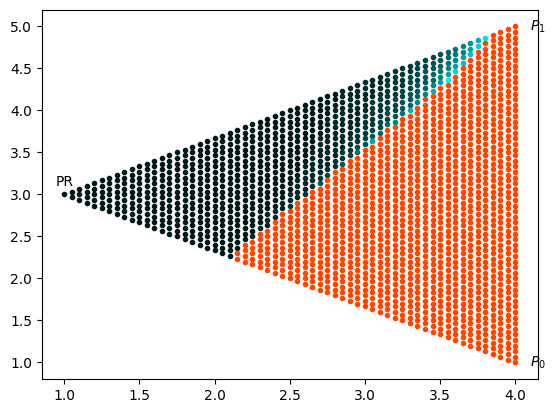

In [63]:
W = torch.tensor([0., 0., 1., 1.,              # f_1(x, a_2) = x
            0., 0., 1., 1.,              # g_1(y, b_2) = y
            0., 0., 0., 1.,              # f_2(x, a_1) = a_1*x
            0., 0., 0., 1.,              # g_2(y, b_1) = b_1*y
            0., 1., 1., 0., 0., 1., 1., 0.,  # f_3(x, a_1, a_2) = a_1 + a_2 mod 2
            0., 1., 1., 0., 0., 1., 1., 0.   # g_3(y, b_1, b_2) = b_1 + b_2 mod 2
            ])

# Set the number of wirings to 1

test_wiring_triangle_with_left_multiplication(
    W = W,
    Box1=non_local_boxes.utils.PR,
    Box1_name = "PR",
    Box2=non_local_boxes.utils.P_0,
    Box2_name = "$P_0$",
    Box3=non_local_boxes.utils.P_1,
    Box3_name = "$P_1$",
    box_grid_size = 60,
    max_box_power = 15,
    threshold = (3 + float(torch.sqrt(torch.tensor(6))))/6
)

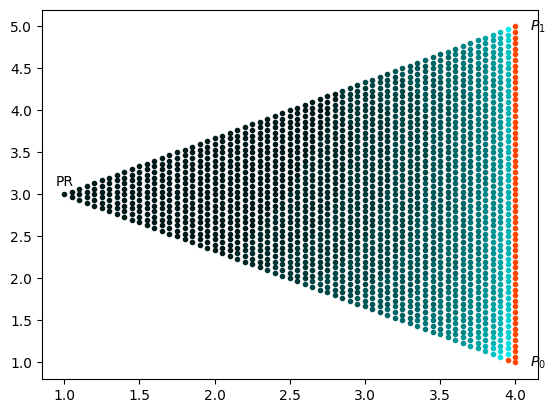

In [64]:
W = torch.tensor([0., 0., 1., 1.,              # f_1(x, a_2) = x
            0., 0., 1., 1.,              # g_1(y, b_2) = y
            0., 0., 0., 1.,              # f_2(x, a_1) = a_1*x
            0., 0., 0., 1.,              # g_2(y, b_1) = b_1*y
            0., 1., 1., 0., 0., 1., 1., 0.,  # f_3(x, a_1, a_2) = a_1 + a_2 mod 2
            0., 1., 1., 0., 0., 1., 1., 0.   # g_3(y, b_1, b_2) = b_1 + b_2 mod 2
            ])

# Set the number of wirings to 1

test_wiring_triangle_with_pairwise_multiplication(
    W = W,
    Box1=non_local_boxes.utils.PR,
    Box1_name = "PR",
    Box2=non_local_boxes.utils.P_0,
    Box2_name = "$P_0$",
    Box3=non_local_boxes.utils.P_1,
    Box3_name = "$P_1$",
    box_grid_size = 60,
    max_box_power = 15,
    threshold = (3 + float(torch.sqrt(torch.tensor(6))))/6
)

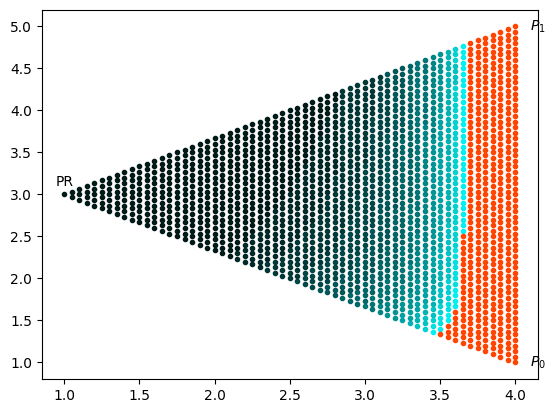

In [65]:
W = torch.tensor([0., 0., 1., 1.,              # f_1(x, a_2) = x
            0., 0., 1., 1.,              # g_1(y, b_2) = y
            0., 0., 0., 1.,              # f_2(x, a_1) = a_1*x
            0., 0., 0., 1.,              # g_2(y, b_1) = b_1*y
            0., 1., 1., 0., 0., 1., 1., 0.,  # f_3(x, a_1, a_2) = a_1 + a_2 mod 2
            0., 1., 1., 0., 0., 1., 1., 0.   # g_3(y, b_1, b_2) = b_1 + b_2 mod 2
            ])

# Set the number of wirings to 1

test_wiring_triangle(
    W = W,
    Box1=non_local_boxes.utils.PR,
    Box1_name = "PR",
    Box2=non_local_boxes.utils.P_0,
    Box2_name = "$P_0$",
    Box3=non_local_boxes.utils.P_1,
    Box3_name = "$P_1$",
    box_grid_size = 60,
    max_box_power = 15,
    threshold = (3 + float(torch.sqrt(torch.tensor(6))))/6,
    Details_Are_Printed=False
)

# Last definition

In [66]:
PR = non_local_boxes.utils.PR
PL = non_local_boxes.utils.P_L
PNL = non_local_boxes.utils.P_NL

W_BS09 = torch.tensor([0., 0., 1., 1.,              # f_1(x, a_2) = x
            0., 0., 1., 1.,              # g_1(y, b_2) = y
            0., 0., 0., 1.,              # f_2(x, a_1) = a_1*x
            0., 0., 0., 1.,              # g_2(y, b_1) = b_1*y
            0., 1., 1., 0., 0., 1., 1., 0.,  # f_3(x, a_1, a_2) = a_1 + a_2 mod 2
            0., 1., 1., 0., 0., 1., 1., 0.   # g_3(y, b_1, b_2) = b_1 + b_2 mod 2
            ])

In [67]:
# Set the number of wirings to 1

def Test_Wiring(W_list, Fixed_box_in_drawings, Fixed_box_name, known_collapsing_W, Details_Are_Printed, compare_with_known_wirings=True):
    # W_list is given as a list here

    if non_local_boxes.evaluate.nb_columns != 1:
        print("WARNING: please change the number of wirings to 1.")
        return " "

    W = torch.tensor(W_list)*1.
    if Details_Are_Printed:
        print("------ Number of known wirings: ", len(known_collapsing_W))
    print("\nW = ",W,"\n")
    if compare_with_known_wirings:
        for i in range(len(known_collapsing_W)):
            if torch.all(W == torch.tensor(known_collapsing_W[i])):
                print(" !!!  This wiring is already known: ",i+1,"th/ ",len(known_collapsing_W),"  !!!")
                return " "
    
    threshold = (3 + float(torch.sqrt(torch.tensor(6))))/6

    # test_wiring_segment(
    #     W = W,
    #     Box1=PR,
    #     Box1_name = "PR",
    #     Box2 = Fixed_box_in_drawings,
    #     Box2_name = Fixed_box_name,
    #     box_grid_size = 60,
    #     max_box_power = 50,
    #     threshold = (3 + float(torch.sqrt(torch.tensor(6))))/6
    # )    

    n = non_local_boxes.evaluate.nb_columns
    p = proportion_blue_points_in_a_segment(torch.t(W.repeat(n, 1)), PR, Fixed_box_in_drawings, 40, 40, threshold)
    texte = ""
    if Details_Are_Printed:
        texte ="------ "
    print(texte,"Proportion of blue points in the segment PR --", Fixed_box_name, ":   ", 100*p, "%")

    if p>0.4:
        boxes_to_be_tested = non_local_boxes.utils.boxes_to_be_tested
        for box_number in boxes_to_be_tested:
            mu, nu, sigma, tau = box_number
            if PL(mu,nu,sigma,tau).tolist() != Fixed_box_in_drawings.tolist():
                test_wiring_triangle(
                    W = W,
                    Box1=PR,
                    Box1_name = "PR",
                    Box2 = Fixed_box_in_drawings,
                    Box2_name = Fixed_box_name,
                    Box3=PL(mu,nu,sigma,tau),
                    Box3_name = "PL"+str(mu)+str(nu)+str(sigma)+str(tau),
                    box_grid_size = 60,
                    max_box_power = 20,
                    threshold = threshold,
                    Details_Are_Printed = Details_Are_Printed
                )
        
        test_wiring_triangle(
            W = W,
            Box1=PR,
            Box1_name = "PR",
            Box2=PL(0,0,0,0),
            Box2_name = "$P_0$",
            Box3=(PR + non_local_boxes.utils.PRprime)/2,
            Box3_name = "(PR+PR') / 2",
            box_grid_size = 60,
            max_box_power = 20,
            threshold = threshold,
            Details_Are_Printed = Details_Are_Printed
        )

    if Details_Are_Printed:
        print("---------- FINISHED ----------")

# Let's Go!

------ Number of known wirings:  79

W =  tensor([0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.0000, 0.0000, 0.0122, 0.0122, 1.0000, 1.0000, 0.0000, 0.0000,
        1.0000, 1.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 1.0000, 1.0000,
        0.0000, 1.0000, 0.0000, 0.0000, 1.0000]) 

------  Proportion of blue points in the segment PR -- PL1000 :    97.5 %
-- Not collapsing:   PR  --  PL0000
-- Not collapsing:   PR  --  PL0001
-- Not collapsing:   PR  --  PL0010
-- Not collapsing:   PR  --  PL0011
-- Not collapsing:   PR  --  PL0100
-- Not collapsing:   PR  --  PL0101
-- Not collapsing:   PR  --  PL0110
-- Not collapsing:   PR  --  PL0111
-- Not collapsing:   PR  --  PL1001
-- Not collapsing:   PR  --  PL1010
-- Not collapsing:   PR  --  PL1011
-- Not collapsing:   PR  --  PL1100
-- Not collapsing:   PR  --  PL1101


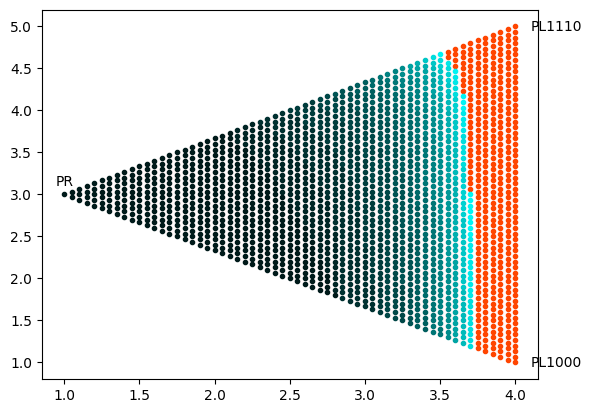

-- Not collapsing:   PR  --  PL1111
-- Not collapsing:   PR  --  (PR+PR') / 2
---------- FINISHED ----------


In [73]:
known_collapsing_W = non_local_boxes.utils.known_collapsing_W

W = [0.    , 1.    , 0.    , 1.    , 0.    , 1.    , 1.    , 1.    , 1.    , 1.    , 0.    , 0.    , 0.0122, 0.0122, 1.    , 1.    , 0.    , 0.    , 1.    , 1.    , 0.    , 0.    , 1.    , 1.    , 0.    , 1.    , 1.    , 0.    , 1.    , 0.    , 0.    , 1.    ]

Test_Wiring(
    W,
    PL(1,0,0,0),
    "PL1000",
    known_collapsing_W,
    Details_Are_Printed = True,
    compare_with_known_wirings=False
)

---
---
---

In [ ]:
i=0

known_collapsing_W = non_local_boxes.utils.known_collapsing_W

for C in [[1., 0., 0., 0.], [0., 1., 0., 0.], [0., 0., 1., 0.], [0., 0., 0., 1.]]:        # TO BE IMPROVED
    for D in [[1., 0., 0., 0.], [0., 1., 0., 0.], [0., 0., 1., 0.], [0., 0., 0., 1.]]:    # TO BE IMPROVED
        for A in [[0.,0.,1.,1.], [1.,1.,0.,0.]]:
            for B in [[0.,0.,1.,1.], [1.,1.,0.,0.]]:
                for E in [[0., 1., 1., 0.], [1., 0., 0., 1.]]:
                    for F in [[0., 1., 1., 0.], [1., 0., 0., 1.]]:
                        for G in [[0., 1., 1., 0.], [1., 0., 0., 1.]]:
                            for H in [[0., 1., 1., 0.], [1., 0., 0., 1.]]:
                                i += 1
                                print(" ")
                                print("--------------   TEST NUMBER ", i, "  --------------")
                                print(" ")

                                W = A+B+C+D+E+F+G+H # concatenation of A, B, C, D, E, F, G H

                                Test_Wiring(
                                    W,
                                    PL(0,0,0,0),
                                    "P_0",
                                    known_collapsing_W, 
                                    False
                                )

---
---
---

In [ ]:
# Check that all known wirings are different.

known_collapsing_W = non_local_boxes.utils.known_collapsing_W

N = len(known_collapsing_W)
print("Number of known wirings: ",N)
for i in range(N-1):
    for j in range(i+1,N):
        if known_collapsing_W[i] == known_collapsing_W[j]:
            print("W_",i+1," and W_",j+1," are the same")
            assert(False)
print("-- finished --")

In [ ]:
torch.tensor(known_collapsing_W[65])

In [ ]:
torch.tensor(known_collapsing_W[66])